In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import Data
books = pd.read_csv('books.csv')
circulations_train = pd.read_csv('circulations-train.csv')
circulations_valid = pd.read_csv('circulations-valid.csv')

In [3]:
# Specify usable column in books 
bk = books[['item_no','bib_no','language','location','title','subject','author']]
bk.head()

,item_no,bib_no,language,location,title,subject,author
0,i1000053,b1000050,eng,Stang Mongkolsuk Library,Food packaging : principles and practice / Gor...,Food Packaging,"Robertson, Gordon L"
1,i1000388,b1000327,eng,Faculty of Nursing Library (Bangkok Noi Campus),From practice to grounded theory : qualitative...,"Nursing Research;""Research"";""Research nurses' ...","Chenitz, W. Carole"
2,i1000441,b1000375,eng,Faculty of Medical Technology Library,"Functional histology / Myrin Borysenko, Theodo...",Histoogical technics examinations questions,"Borysenko, Myrin"
3,i1000511,b1000436,eng,Stang Mongkolsuk Library,Fundamentals of analytical chemistry / Douglas...,"Chemistry, Analytic","Skoog, Douglas Arvid"
4,i1000551,b1000465,tha,Central Library,น้ำใสธรรมชาติสวย / กลุ่มบริษัทพรีเมียร์,"การอนุรักษ์ธรรมชาติ ไทย ภาพ;""การอนุรักษ์น้ำ ไท...",<MISSING>


In [4]:
# Adjust columns in circulation_valid
circulations_valid.head()
cirval = circulations_valid.drop(columns=['id','patron_hint'])
cirval.head(1)

,tx_date,due_date,tx_type,item_no,bib_no,language,patron_no,patron_type
0,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad


In [5]:
cirval = pd.merge(cirval, bk[['bib_no','subject']], on='bib_no', how='inner')
cirval.head()

,tx_date,due_date,tx_type,item_no,bib_no,language,patron_no,patron_type,subject
0,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad,"Special Service : MUIC Group Study Room Keys;""..."
1,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad,"Special Service : MUIC Group Study Room Keys;""..."
2,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad,"Special Service : MUIC Group Study Room Keys;""..."
3,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad,"Special Service : MUIC Group Study Room Keys;""..."
4,2022-07-01 07:54:37,2022-07-04 04:00:00,Check out,i1989881,b1468724,tha,p1163536,IC Undergrad,"Special Service : MUIC Group Study Room Keys;""..."


In [6]:
# Split date and time but keep only date
cirval[['tx_date', 'tx_time']] = cirval['tx_date'].str.split(' ', expand=True)
cirval.drop('tx_time', axis=1, inplace=True)
cirval[['due_date', 'due_time']] = cirval['due_date'].str.split(' ', expand=True)
cirval.drop('due_time', axis=1, inplace=True)

# Change datatype from object to datetime
cirval['tx_date'] = pd.to_datetime(cirval['tx_date'])
cirval['due_date'] = pd.to_datetime(cirval['due_date'])

# calculate duration between 'tx_date' and 'due_date' and store in 'duration' column
cirval['duration'] = (cirval['due_date'] - cirval['tx_date']).dt.days.astype(float)

In [7]:
# For exist users
## Count number of duplicated time that users borrow the book
user_count = cirval.groupby('patron_no')['subject'].value_counts()
user_count.head(20)

patron_no  subject                                                                                                                                                                                     
p1000012   ภาษาอังกฤษ การใช้ภาษา;"ภาษาอังกฤษ ไวยากรณ์"                                                                                                                                                      2
           ภาษาอังกฤษ ไวยากรณ์;"ภาษาอังกฤษ การเขียน";"TOEIC"                                                                                                                                                2
           ไมโครซอฟต์เอ็กเซล;"สารสนเทศทางการแพทย์ โปรแกรมคอมพิวเตอร์";"Microsoft Excel for Windows (Computer program)"                                                                                      2
           English language Usage;"English language Errors of usage"                                                                                                                  

In [8]:
# For exist users
## Count amount of distinct type of book that users borrow
user_count = cirval.groupby('patron_no')['subject'].nunique().sort_values(ascending=False)
user_count.head(10)

patron_no
p1152811    71
p1011452    49
p1132862    34
p1063822    34
p1100424    31
p1112336    30
p1018755    26
p1032797    25
p1018746    24
p1158775    24
Name: subject, dtype: int64

In [9]:
# List of existing members
member_list = cirval['patron_no'].drop_duplicates().reset_index(drop=True).astype(str)
member_list.head()

0    p1163536
1    p1164001
2    p1163927
3    p1163317
4    p1170210
Name: patron_no, dtype: object

In [10]:
# Input Patron Id for recommendation 
while True:
    ans = str(input('Please enter your Patron ID: '))
    if member_list.str.contains(str(ans)).any():
        break   


In [11]:
# Create a dataframe that contain data for the ID that has been entered
for_member = cirval[cirval['patron_no']==ans].reset_index(drop=True)
for_member.head()

,tx_date,due_date,tx_type,item_no,bib_no,language,patron_no,patron_type,subject,duration
0,2022-11-26,2022-12-16,Check out,i1896386,b1471720,eng,p1103175,Faculty,"Mahidol University Dissertations;""Mahidol Univ...",20.0
1,2022-11-26,2022-12-16,Check out,i1896386,b1471720,eng,p1103175,Faculty,"Mahidol University Dissertations;""Mahidol Univ...",20.0
2,2022-11-26,2022-12-16,Check out,i1896386,b1471720,eng,p1103175,Faculty,"Mahidol University Dissertations;""Mahidol Univ...",20.0
3,2022-11-26,2022-12-16,Check out,i1896386,b1471720,eng,p1103175,Faculty,"Mahidol University Dissertations;""Mahidol Univ...",20.0
4,2022-07-05,2022-07-25,Self-renew,i1919829,b1492520,eng,p1103175,Faculty,"Mahidol University Dissertations;""Mahidol Univ...",20.0


In [12]:
count = for_member.groupby('patron_no')['subject'].nunique().sort_values(ascending=False)
count.head()

patron_no
p1103175    16
Name: subject, dtype: int64

In [13]:
# Temporary Lists
temp_list1 = list(for_member['bib_no'].drop_duplicates())
temp_list2 = list(for_member['subject'].drop_duplicates())

# Select books that contains the  same subject as the user interested in
for i in temp_list1:
    bk_for_rec = bk[bk['bib_no'] != str(i) ]
bk_for_rec = bk_for_rec[bk_for_rec['subject'].isin(temp_list2)]

bk_for_rec.head(10)

,item_no,bib_no,language,location,title,subject,author
1282,i1126719,b1059523,tha,Central Library,การวิเคราะห์ประสิทธิผลการให้บริการสาธารณสุขของ...,"มหาวิทยาลัยมหิดล วิทยานิพนธ์;""มหาวิทยาลัยมหิดล...",วลัยพร เตียวพิพิธพร
5687,i1477452,b1219799,eng,Ramathibodi Medical Library,Mild cognitive impairment : aging to Alzheimer...,"Cognition Disorders diagnosis Aged;""Aging psyc...",<MISSING>
6084,i1493781,b1225236,eng,Institute for Population and Social Research L...,Research methodology : a step-by-step guide fo...,"Research Methodology;""Social sciences Research...","Kumar, Ranjit"
6684,i1514660,b1225236,eng,Institute for Population and Social Research L...,Research methodology : a step-by-step guide fo...,"Research Methodology;""Social sciences Research...","Kumar, Ranjit"
11660,i1635560,b1248666,eng,Surasak Srisuk Library (Faculty of Physical Th...,Conditions in occupational therapy : effect on...,"Occupational Therapy;""Nervous System Diseases""...",<MISSING>
11670,i1635835,b1225236,eng,ASEAN Institute for Health Development Library,Research methodology : a step-by-step guide fo...,"Research Methodology;""Social sciences Research...","Kumar, Ranjit"
13913,i1677519,b1314372,tha,Siriraj Medical Library,การบำบัดรักษาทางกิจกรรมบำบัดสำหรับผู้ที่มีความ...,ความบกพร่องทางการเรียนรู้ ผู้ป่วย การฟื้นฟูสมร...,<MISSING>
18828,i1756402,b1380902,eng,ASEAN Institute for Health Development Library,Prevalence and risk factors of work related mu...,"Mahidol University Dissertations;""Mahidol Univ...","Soe, Kyaw Thu, 1985-"
18829,i1756403,b1380902,eng,ASEAN Institute for Health Development Library,Prevalence and risk factors of work related mu...,"Mahidol University Dissertations;""Mahidol Univ...","Soe, Kyaw Thu, 1985-"
21111,i1793042,b1410560,eng,ASEAN Institute for Health Development Library,Research methodology : a step-by-step guide fo...,"Research Methodology;""Social sciences Research...","Kumar, Ranjit"


In [14]:
# Start training model
cirtrain = circulations_train.drop(columns=['id','patron_hint'])
cirtrain = pd.merge(cirtrain, bk[['bib_no','subject']], on='bib_no', how='inner')
cirtrain.head()

,tx_date,due_date,tx_type,item_no,bib_no,language,patron_no,patron_type,subject
0,2021-01-05 09:05:50,2021-02-01 04:00:00,Check out,i1659740,b1304132,eng,p1100424,IC Faculty,"Krakauer, Jon;""Adventure Consultants Guided Ex..."
1,2021-01-05 09:07:13,2021-02-01 04:00:00,Check out,i1807938,b1419270,tha,p1136338,Temp Staff,"ความสำเร็จ;""จิตวิทยาประยุกต์"";""การดำเนินชีวิต"""
2,2021-01-21 12:06:01,2021-02-01 04:00:00,Check out,i1807938,b1419270,tha,p1136338,Temp Staff,"ความสำเร็จ;""จิตวิทยาประยุกต์"";""การดำเนินชีวิต"""
3,2021-02-01 09:45:29,2021-02-11 04:00:00,Self-renew,i1807938,b1419270,tha,p1136338,Temp Staff,"ความสำเร็จ;""จิตวิทยาประยุกต์"";""การดำเนินชีวิต"""
4,2021-01-05 09:07:46,2021-02-01 04:00:00,Check out,i1906011,b1485317,tha,p1105182,Univ Staff/Admin,"ความเรียง;""การดำเนินชีวิต"""


In [15]:
# Find the record of the entered patron id
for_train = cirtrain[cirtrain['patron_no']==ans].reset_index(drop=True)
for_train.head()

,tx_date,due_date,tx_type,item_no,bib_no,language,patron_no,patron_type,subject
0,2021-03-01 10:45:30,2021-03-22 04:00:00,Check out,i1884323,b1410560,eng,p1103175,Faculty,"Research Methodology;""Social sciences Research..."
1,2021-03-01 10:45:30,2021-03-22 04:00:00,Check out,i1884323,b1410560,eng,p1103175,Faculty,"Research Methodology;""Social sciences Research..."
2,2021-03-01 10:45:30,2021-03-22 04:00:00,Check out,i1884323,b1410560,eng,p1103175,Faculty,"Research Methodology;""Social sciences Research..."
3,2021-03-23 09:01:00,2021-04-16 04:00:00,Check out,i1884323,b1410560,eng,p1103175,Faculty,"Research Methodology;""Social sciences Research..."
4,2021-03-23 09:01:00,2021-04-16 04:00:00,Check out,i1884323,b1410560,eng,p1103175,Faculty,"Research Methodology;""Social sciences Research..."


In [16]:
#Create list of books 
book_list_for_train = for_train['bib_no'].drop_duplicates().astype(str)
book_list_valid = bk_for_rec['bib_no'].drop_duplicates().astype(str)

# calculate shared and distinct values
merged_df = pd.merge(book_list_for_train, book_list_valid, how='outer', indicator=True)
shared_values = len(merged_df[merged_df['_merge'] == 'both'])
distinct_values = len(merged_df[merged_df['_merge'] == 'right_only'])

print("Number of books that have in common: ", shared_values)
print("Number of distinct books: ", distinct_values)


Number of books that have in common:  7
Number of distinct books:  10


In [17]:
# p1032797
# Common 18 Incommon 8

In [18]:
# List of Books that is reccommended
bk_for_rec[['bib_no','title']].drop_duplicates(subset='bib_no').reset_index().drop(columns='index').head(20)

,bib_no,title
0,b1059523,การวิเคราะห์ประสิทธิผลการให้บริการสาธารณสุขของ...
1,b1219799,Mild cognitive impairment : aging to Alzheimer...
2,b1225236,Research methodology : a step-by-step guide fo...
3,b1248666,Conditions in occupational therapy : effect on...
4,b1314372,การบำบัดรักษาทางกิจกรรมบำบัดสำหรับผู้ที่มีความ...
5,b1380902,Prevalence and risk factors of work related mu...
6,b1410560,Research methodology : a step-by-step guide fo...
7,b1417671,อดัม สมิท vs ชาร์ลส์ ดาร์วิน ใครกันแน่ที่เป็นข...
8,b1279765,การบำบัดรักษาทางกิจกรรมบำบัดสำหรับผู้ที่มีความ...
9,b1452984,Prevalence and risk factors of under-nutrition...


In [19]:
book_list_for_train.head(20)

0      b1410560
24     b1492520
30     b1496442
36     b1456101
42     b1471532
44     b1431302
50     b1469559
56     b1489056
62     b1469572
68     b1322974
74     b1256081
92     b1248666
104    b1278374
110    b1431238
116    b1398226
127    b1059523
128    b1469151
Name: bib_no, dtype: object

In [20]:
ac_ratio_list = []
for i in list(member_list):
    for_member = cirval[cirval['patron_no']==i].reset_index(drop=True)
    for_train = cirtrain[cirtrain['patron_no']==i].reset_index(drop=True)
    # Temporary Lists
    temp_list1 = list(for_member['bib_no'].drop_duplicates())
    temp_list2 = list(for_member['subject'].drop_duplicates())

    # Select books that contains the  same subject as the user interested in
    for j in temp_list1:
        bk_for_rec = bk[bk['bib_no'] != str(j) ]
    bk_for_rec = bk_for_rec[bk_for_rec['subject'].isin(temp_list2)]
    #Create list of books 
    book_list_for_train = for_train['bib_no'].drop_duplicates().astype(str)
    book_list_valid = bk_for_rec['bib_no'].drop_duplicates().astype(str)

    # calculate shared and distinct values
    merged_df = pd.merge(book_list_for_train, book_list_valid, how='outer', indicator=True)
    shared_values = len(merged_df[merged_df['_merge'] == 'both'])
    distinct_values = len(merged_df[merged_df['_merge'] == 'right_only'])
    if len(bk_for_rec[['bib_no','title']].drop_duplicates(subset='bib_no').reset_index().drop(columns='index')['bib_no']) != 0:
        ac_ratio = shared_values/(len(bk_for_rec[['bib_no','title']].drop_duplicates(subset='bib_no').reset_index().drop(columns='index')['bib_no']))
    else:
        ac_ratio = 0
    # Append accuracy ratio in list
    ac_ratio_list.append(ac_ratio)
    
print(ac_ratio_list)
    
    
    
    

KeyboardInterrupt: 

In [ ]:
AVG_Accuracy_Ratio = np.mean(ac_ratio_list)
print('This model accuracy is '+str(AVG_Accuracy_Ratio*100)+' percent.')

This model accuracy is 26.725858122786633 percent.


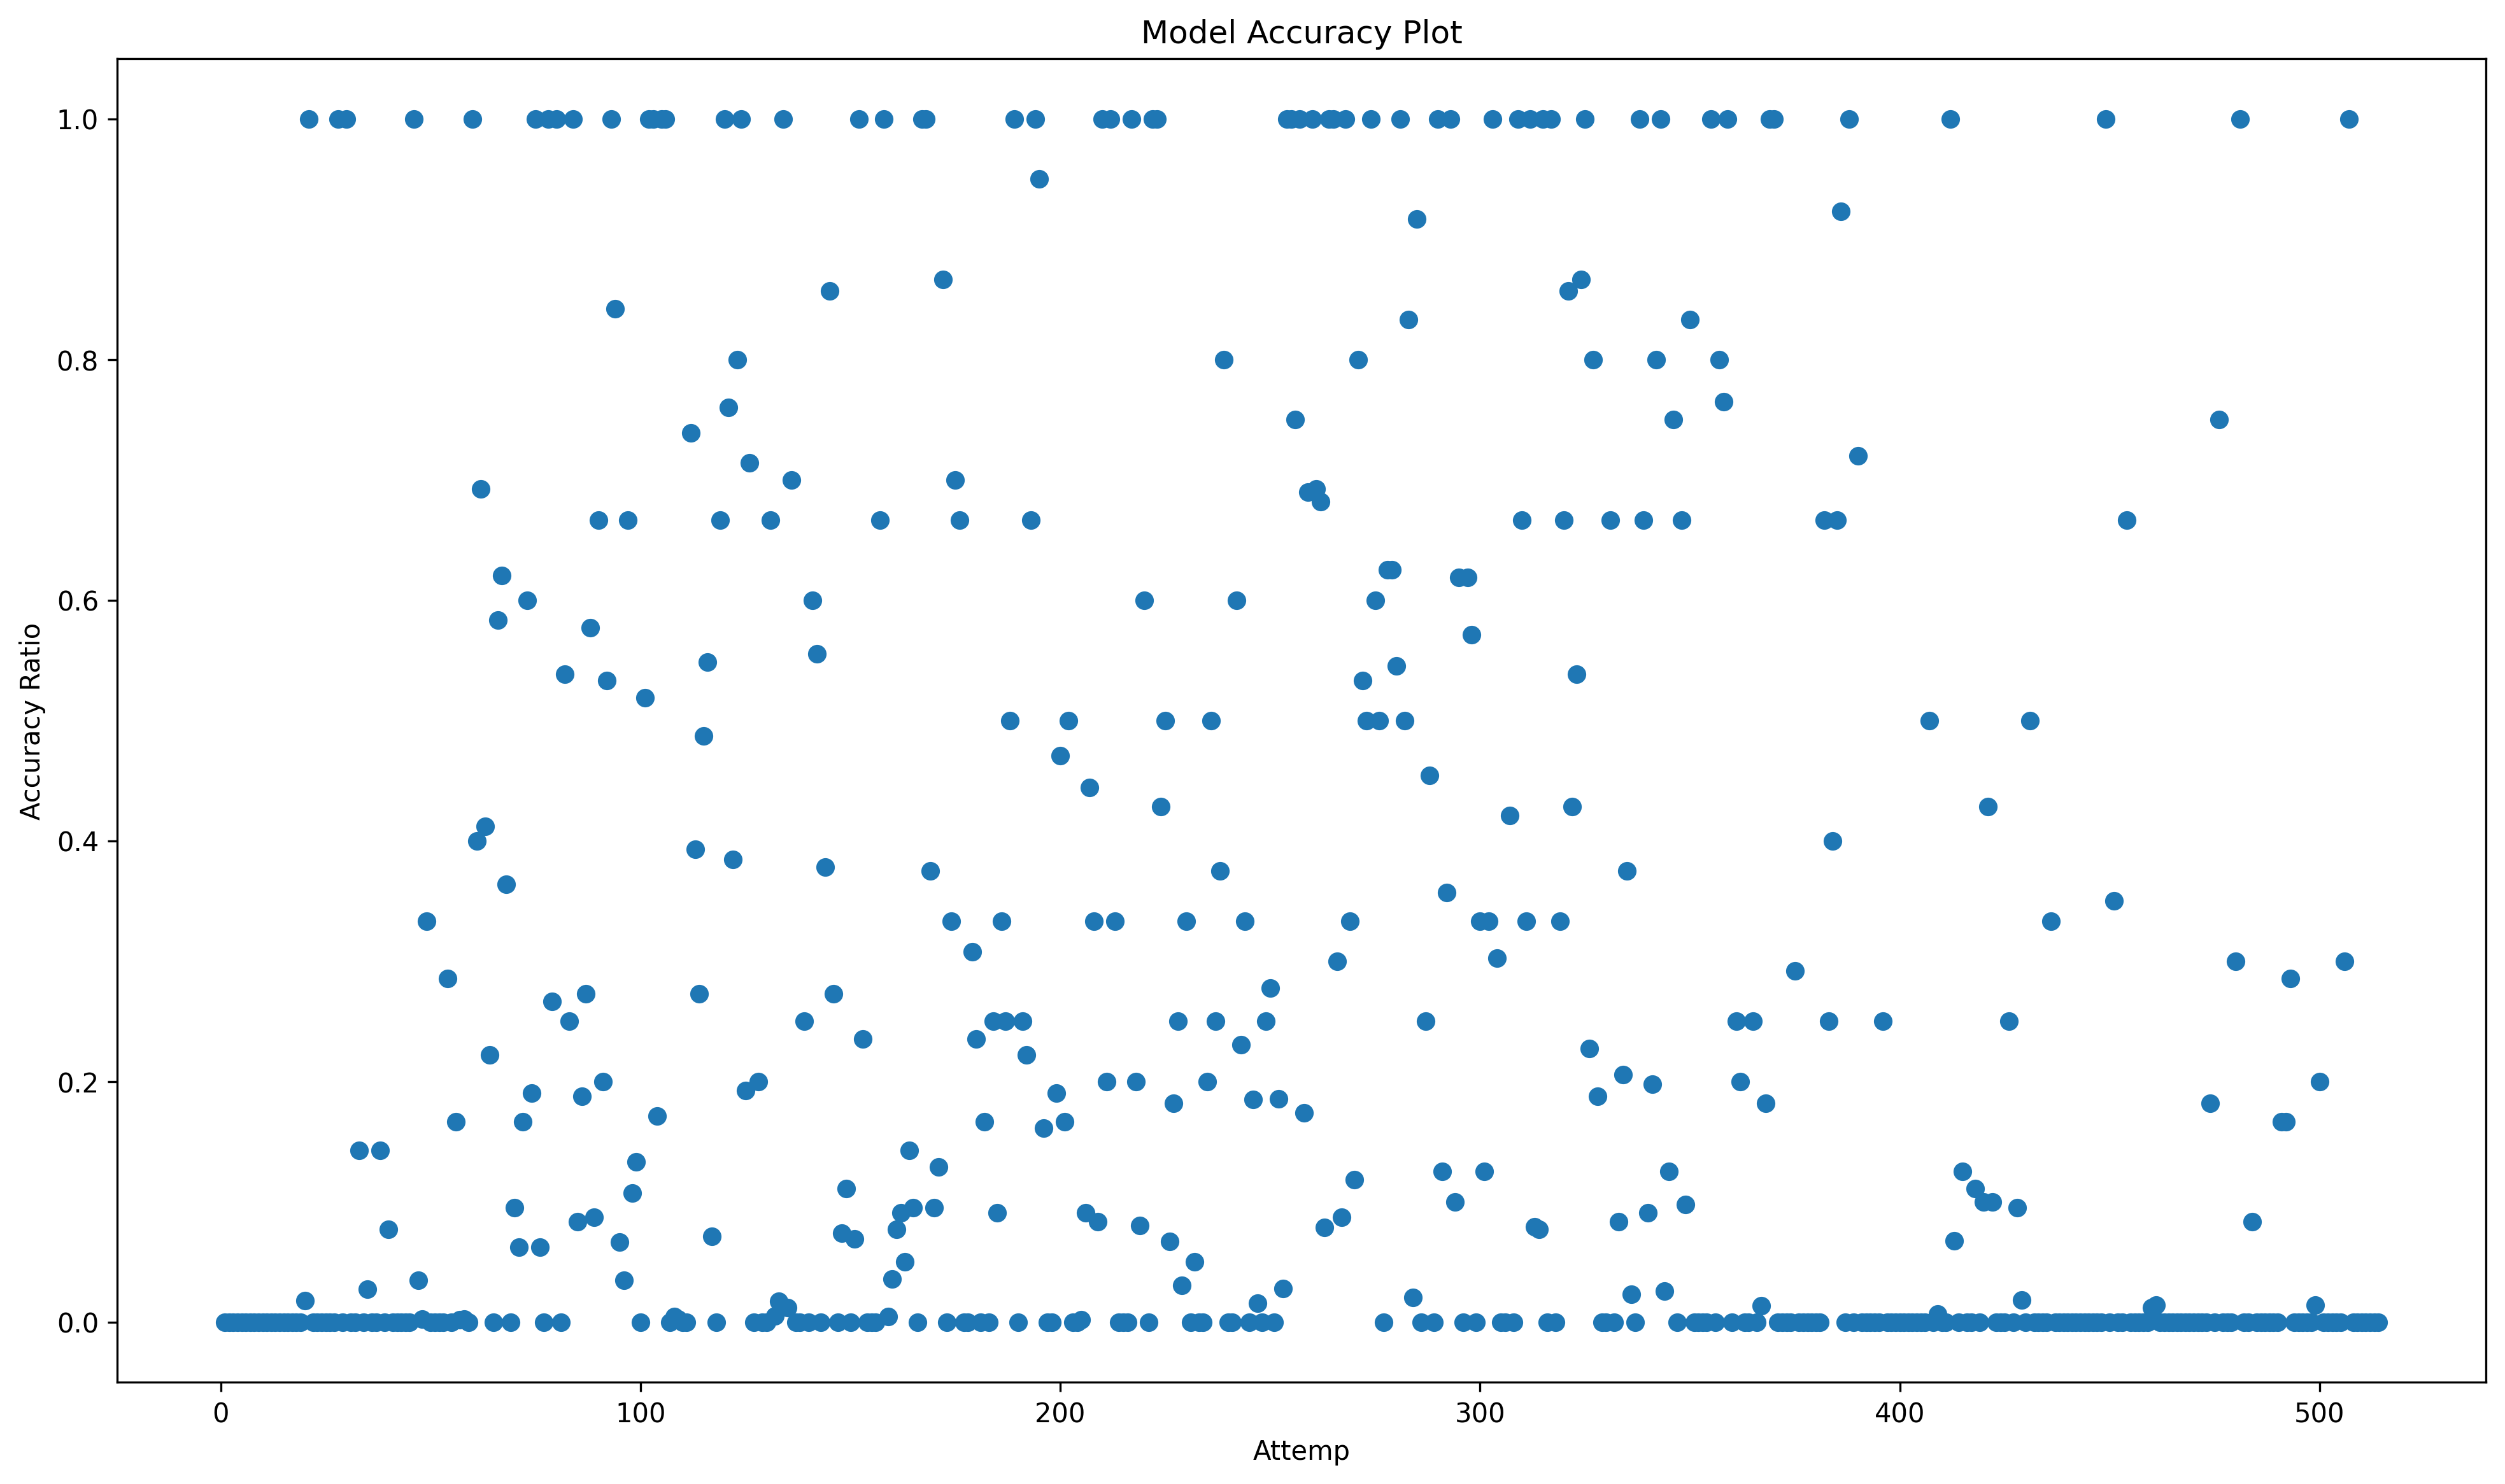

In [ ]:
# Specify Y variable
y = np.array(ac_ratio_list)

# Create x values starting from 1 and ending at the length of y
x = np.arange(1, len(y)+1)

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Attemp')
plt.ylabel('Accuracy Ratio')
plt.title('Model Accuracy Plot')

# Set the figure size and resolution
fig = plt.gcf()
fig.set_size_inches(16, 9)  # 16x9 aspect ratio
fig.set_dpi(300)  # 300 dpi

# Save the plot as a 4k resolution PNG file
plt.savefig('scatter_plot_4k.png', dpi=3000)

# Show the plot
plt.show()

In [ ]:
# Read text
check_list = pd.read_csv('test-patrons.txt', header=None)
patron_check_list = list(check_list[0])
print(patron_check_list)

['p1000004', 'p1000042', 'p1000064', 'p1000468', 'p1001986', 'p1002253', 'p1002791', 'p1003660', 'p1004323', 'p1004851', 'p1004966', 'p1005707', 'p1006944', 'p1007784', 'p1008414', 'p1008582', 'p1009762', 'p1009861', 'p1010486', 'p1010519', 'p1011601', 'p1012183', 'p1012309', 'p1012379', 'p1013952', 'p1016260', 'p1017212', 'p1018245', 'p1018770', 'p1018795', 'p1022095', 'p1022401', 'p1023563', 'p1025487', 'p1026607', 'p1026615', 'p1026805', 'p1029609', 'p1029870', 'p1032731', 'p1033144', 'p1034481', 'p1038353', 'p1039618', 'p1039660', 'p1039926', 'p1040587', 'p1040844', 'p1041508', 'p1042799', 'p1043923', 'p1044921', 'p1044925', 'p1045260', 'p1045888', 'p1046424', 'p1047343', 'p1047347', 'p1047730', 'p1049254', 'p1054079', 'p1054719', 'p1055669', 'p1056383', 'p1056413', 'p1058333', 'p1062834', 'p1063501', 'p1063545', 'p1063609', 'p1063644', 'p1068879', 'p1070040', 'p1073906', 'p1074386', 'p1076172', 'p1077251', 'p1077487', 'p1078385', 'p1080249', 'p1082806', 'p1083387', 'p1084371', 'p1

In [ ]:
final_list = pd.DataFrame(columns=['patron_no', 'bib_no', 'score'])

for i in patron_check_list:
    for_member = cirtrain[cirtrain['patron_no']==i].reset_index(drop=True)
    for_train = cirtrain[cirtrain['patron_no']==i].reset_index(drop=True)
    # Temporary Lists
    temp_list1 = list(for_member['bib_no'].drop_duplicates())
    temp_list2 = list(for_member['subject'].drop_duplicates())

    # Select books that contains the  same subject as the user interested in
    for j in temp_list1:
        bk_for_rec = bk[bk['bib_no'] != str(j) ]
    bk_for_rec = bk_for_rec[bk_for_rec['subject'].isin(temp_list2)]
    bk_id_list = list(bk_for_rec['bib_no'].drop_duplicates())
    
    if len(bk_id_list) == 0:
        final_list = final_list.append({'patron_no': i, 'bib_no': 'b1468724', 'score': 1}, ignore_index=True)
        final_list = final_list.append({'patron_no': i, 'bib_no': 'b1275238', 'score': 1}, ignore_index=True)
    elif len(bk_id_list) > 30:    
        for k in range(30):
            final_list = final_list.append({'patron_no': i, 'bib_no': bk_id_list[k], 'score': 1}, ignore_index=True)
    else:    
        for k in range(len(bk_id_list)):
            final_list = final_list.append({'patron_no': i, 'bib_no': bk_id_list[k], 'score': 1}, ignore_index=True)
  



C:\Users\ASUS\AppData\Local\Temp\ipykernel_15556\2630496640.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_list = final_list.append({'patron_no': i, 'bib_no': bk_id_list[k], 'score': 1}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15556\2630496640.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_list = final_list.append({'patron_no': i, 'bib_no': bk_id_list[k], 'score': 1}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15556\2630496640.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_list = final_list.append({'patron_no': i, 'bib_no': bk_id_list[k], 'score': 1}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15556\2630496640.py:24: FutureWarnin

In [ ]:
final_list.head(500)

,patron_no,bib_no,score
0,p1000004,b1295882,1
1,p1000004,b1424661,1
2,p1000004,b1495802,1
3,p1000042,b1278360,1
4,p1000042,b1250281,1
...,...,...,...
495,p1000064,b1471932,1
496,p1000064,b1471968,1
497,p1000064,b1275804,1
498,p1000064,b1472200,1


In [ ]:
final_list.to_csv('final_list.csv', index=False)

In [ ]:
ccc = cirval['bib_no'].value_counts()
ccc.head(20)

b1468724    3514
b1275238    3294
b1312611     364
b1280517     195
b1261029     155
b1367380     152
b1297970     144
b1506364     140
b1430489     140
b1395773     126
b1432045     114
b1506166      96
b1424129      90
b1468675      90
b1466192      80
b1110132      80
b1490285      72
b1413873      70
b1464748      65
b1410560      60
Name: bib_no, dtype: int64